# V6 Phase 1: Visual Feature Extraction

## Goal
Generate visual embeddings for each hieroglyph using a pre-trained CNN (ResNet50).

## Approach
1. **Render Glyphs**: Use the Djehuty font to render each hieroglyph as a high-resolution image (224x224).
2. **Pre-trained CNN**: Use ResNet50 (trained on ImageNet) as a feature extractor.
3. **Extract Features**: Get the 2048-dimensional vector from the penultimate layer.
4. **Dimensionality Reduction**: (Optional) Reduce to 300d/500d to match text embeddings.
5. **Save**: Create a `visual_embeddings.pkl` map for alignment.

## Why Render to Image?
- **Transfer Learning**: CNNs are powerful visual feature extractors.
- **Robustness**: Captures shape, density, and complexity better than raw vector coordinates.
- **Compatibility**: Standardizes input for multimodal models.

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from pathlib import Path
import matplotlib.pyplot as plt

# Check device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✓ Using device: {device}")

✓ Using device: mps


## 1. Load Lexicon and Font

In [2]:
# Load lexicon
with open('../data/processed/hieroglyph_lexicon.json', 'r') as f:
    lexicon = json.load(f)

print(f"✓ Loaded {len(lexicon)} glyphs")

# Font path
FONT_PATH = '../data/raw/EgyptianHiero4.03.ttf'
if not Path(FONT_PATH).exists():
    raise FileNotFoundError(f"Font not found at {FONT_PATH}")

✓ Loaded 1071 glyphs


## 2. Initialize ResNet50 Feature Extractor

In [3]:
# Load pre-trained ResNet50
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Remove classification head (fc layer)
# We want the 2048-dim feature vector before the final classification
modules = list(resnet.children())[:-1]
feature_extractor = torch.nn.Sequential(*modules)
feature_extractor.to(device)
feature_extractor.eval()

print("✓ ResNet50 initialized (classification head removed)")

# Image transforms
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # Normalize with ImageNet mean/std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

✓ ResNet50 initialized (classification head removed)


## 3. Render and Extract Features

/Users/crashy/.pyenv/versions/3.12.3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 77824 (\N{EGYPTIAN HIEROGLYPH A001}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


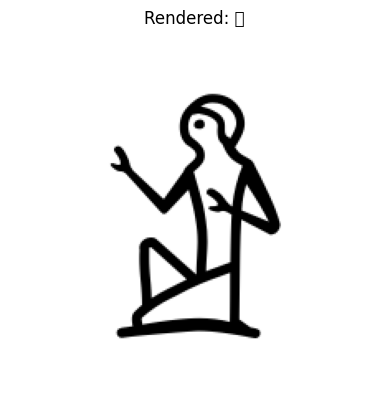

In [4]:
def render_glyph(character, font_path, size=224):
    """
    Render a glyph character to a PIL Image.
    """
    # Create white canvas
    image = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(image)
    
    # Load font (size needs to be adjusted to fit)
    # 180 seems like a good size for 224x224
    font = ImageFont.truetype(font_path, size=int(size * 0.8))
    
    # Center the glyph
    # Get bounding box
    bbox = draw.textbbox((0, 0), character, font=font)
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    
    x = (size - w) / 2 - bbox[0]
    y = (size - h) / 2 - bbox[1]
    
    # Draw black glyph
    draw.text((x, y), character, font=font, fill='black')
    
    return image

# Test render
test_glyph = lexicon[0]['character']
img = render_glyph(test_glyph, FONT_PATH)
plt.imshow(img)
plt.axis('off')
plt.title(f"Rendered: {test_glyph}")
plt.show()

In [5]:
# Extract features for all glyphs
visual_embeddings = {}
batch_size = 32

print("Extracting visual features...")

with torch.no_grad():
    for i in tqdm(range(0, len(lexicon), batch_size)):
        batch = lexicon[i:i+batch_size]
        images = []
        valid_indices = []
        
        for idx, item in enumerate(batch):
            try:
                img = render_glyph(item['character'], FONT_PATH)
                tensor = preprocess(img)
                images.append(tensor)
                valid_indices.append(idx)
            except Exception as e:
                print(f"Error rendering {item['gardiner_code']}: {e}")
        
        if not images:
            continue
            
        # Stack batch
        input_tensor = torch.stack(images).to(device)
        
        # Forward pass
        features = feature_extractor(input_tensor)
        
        # Flatten (N, 2048, 1, 1) -> (N, 2048)
        features = features.view(features.size(0), -1)
        
        # Store results
        features_np = features.cpu().numpy()
        
        for j, feat in zip(valid_indices, features_np):
            item = batch[j]
            # Store by Gardiner code (primary key)
            visual_embeddings[item['gardiner_code']] = feat
            # Also store by Unicode for convenience
            visual_embeddings[item['unicode']] = feat

print(f"\n✓ Generated embeddings for {len(visual_embeddings)//2} unique glyphs")

Extracting visual features...


  0%|            | 0/34 [00:00<?, ?it/s]

  3%|    | 1/34 [00:00<00:18,  1.78it/s]

  6%|▏   | 2/34 [00:00<00:12,  2.62it/s]

  9%|▎   | 3/34 [00:01<00:10,  2.93it/s]

 12%|▍   | 4/34 [00:01<00:09,  3.23it/s]

 15%|▌   | 5/34 [00:01<00:08,  3.58it/s]

 18%|▋   | 6/34 [00:01<00:07,  3.75it/s]

 21%|▊   | 7/34 [00:02<00:06,  3.93it/s]

 24%|▉   | 8/34 [00:02<00:06,  4.09it/s]

 26%|█   | 9/34 [00:02<00:05,  4.28it/s]

 29%|▉  | 10/34 [00:02<00:05,  4.44it/s]

 32%|▉  | 11/34 [00:02<00:05,  4.38it/s]

 35%|█  | 12/34 [00:03<00:05,  4.33it/s]

 38%|█▏ | 13/34 [00:03<00:04,  4.39it/s]

 41%|█▏ | 14/34 [00:03<00:04,  4.09it/s]

 44%|█▎ | 15/34 [00:03<00:04,  4.13it/s]

 47%|█▍ | 16/34 [00:04<00:04,  4.23it/s]

 50%|█▌ | 17/34 [00:04<00:03,  4.33it/s]

 53%|█▌ | 18/34 [00:04<00:03,  4.36it/s]

 56%|█▋ | 19/34 [00:04<00:03,  4.46it/s]

 59%|█▊ | 20/34 [00:05<00:03,  4.57it/s]

 62%|█▊ | 21/34 [00:05<00:02,  4.66it/s]

 65%|█▉ | 22/34 [00:05<00:02,  4.65it/s]

 68%|██ | 23/34 [00:05<00:02,  4.57it/s]

 71%|██ | 24/34 [00:05<00:02,  4.49it/s]

 74%|██▏| 25/34 [00:06<00:02,  4.42it/s]

 76%|██▎| 26/34 [00:06<00:01,  4.38it/s]

 79%|██▍| 27/34 [00:06<00:01,  4.41it/s]

 82%|██▍| 28/34 [00:06<00:01,  4.47it/s]

 85%|██▌| 29/34 [00:07<00:01,  4.55it/s]

 88%|██▋| 30/34 [00:07<00:00,  4.65it/s]

 91%|██▋| 31/34 [00:07<00:00,  4.73it/s]

 94%|██▊| 32/34 [00:07<00:00,  4.79it/s]

 97%|██▉| 33/34 [00:07<00:00,  4.78it/s]

100%|███| 34/34 [00:08<00:00,  4.71it/s]

100%|███| 34/34 [00:08<00:00,  4.23it/s]


✓ Generated embeddings for 535 unique glyphs


from sklearn.decomposition import PCA

# Target Dimension Strategy: BERT Base Alignment
# - 2048d: ResNet50 raw output
# - 768d: BERT Base standard dimension
# - Strategy: Reduce visual features to 768d so they can be directly
#             integrated with BERT models or used for joint training.
TARGET_DIM = 768

# Convert to matrix
keys = sorted([k for k in visual_embeddings.keys() if k.startswith('U+')]) # Use Unicode keys to avoid dupes
X = np.array([visual_embeddings[k] for k in keys])

print(f"Feature matrix shape: {X.shape}")

# PCA to TARGET_DIM components
pca = PCA(n_components=TARGET_DIM)
X_reduced = pca.fit_transform(X)

print(f"Reduced shape: {X_reduced.shape}")
print(f"Explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Update embeddings dictionary with reduced vectors
visual_embeddings_reduced = {}
for k, vec in zip(keys, X_reduced):
    visual_embeddings_reduced[k] = vec
    
# Also map Gardiner codes
for item in lexicon:
    if item['unicode'] in visual_embeddings_reduced:
        visual_embeddings_reduced[item['gardiner_code']] = visual_embeddings_reduced[item['unicode']]

In [6]:
from sklearn.decomposition import PCA

# Target Dimension Strategy: BERT Base Alignment
# - 2048d: ResNet50 raw output
# - 768d: BERT Base standard dimension
# - Strategy: Reduce visual features to 768d so they can be directly
#             integrated with BERT models or used for joint training.
TARGET_DIM = 768

# Convert to matrix
keys = sorted([k for k in visual_embeddings.keys() if k.startswith('U+')]) # Use Unicode keys to avoid dupes
X = np.array([visual_embeddings[k] for k in keys])

print(f"Feature matrix shape: {X.shape}")

# PCA to TARGET_DIM components
pca = PCA(n_components=TARGET_DIM)
X_reduced = pca.fit_transform(X)

print(f"Reduced shape: {X_reduced.shape}")
print(f"Explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Update embeddings dictionary with reduced vectors
visual_embeddings_reduced = {}
for k, vec in zip(keys, X_reduced):
    visual_embeddings_reduced[k] = vec
    
# Also map Gardiner codes
for item in lexicon:
    if item['unicode'] in visual_embeddings_reduced:
        visual_embeddings_reduced[item['gardiner_code']] = visual_embeddings_reduced[item['unicode']]

Feature matrix shape: (1071, 2048)


Reduced shape: (1071, 768)
Explained variance: 0.9986


## 5. Save Embeddings

In [7]:
import pickle

# Save full (2048d)
with open('../data/processed/visual_embeddings_2048d.pkl', 'wb') as f:
    pickle.dump(visual_embeddings, f)

# Save reduced (Target Dim)
output_path = f'../data/processed/visual_embeddings_{TARGET_DIM}d.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(visual_embeddings_reduced, f)

print(f"✓ Saved embeddings to {output_path}")

✓ Saved embeddings to ../data/processed/visual_embeddings_768d.pkl


## 6. Visualization: Visual Similarity Search

Let's verify the embeddings work by finding visually similar glyphs.

Query: U+13000


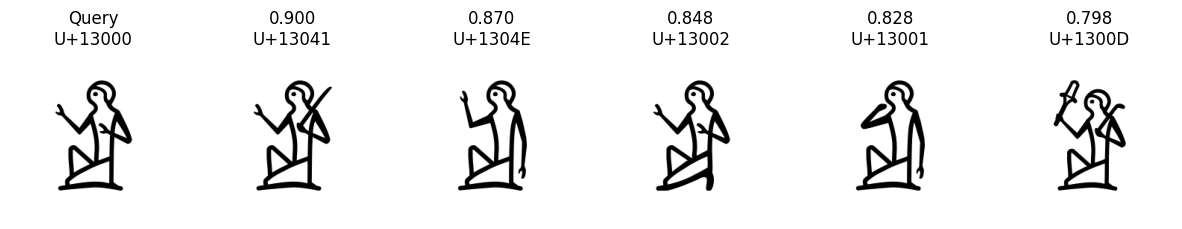

Query: U+1313F


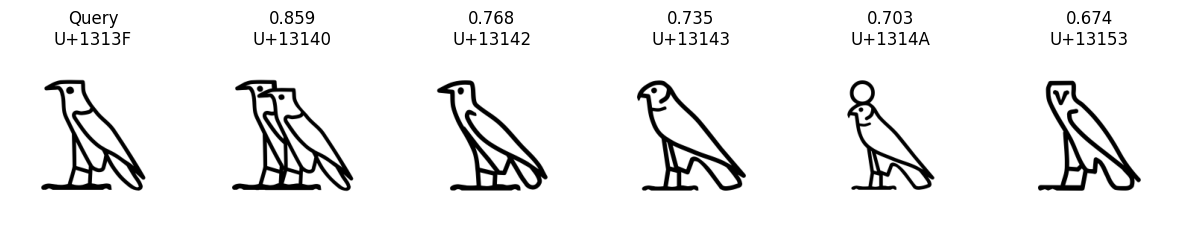

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_glyphs(query_code, top_k=5):
    if query_code not in visual_embeddings_reduced:
        print(f"Glyph {query_code} not found")
        return
        
    query_vec = visual_embeddings_reduced[query_code].reshape(1, -1)
    
    # Compute similarity to all others
    sims = []
    for k, v in visual_embeddings_reduced.items():
        if k.startswith('U+') and k != query_code: # Avoid dupes and self
            sim = cosine_similarity(query_vec, v.reshape(1, -1))[0][0]
            sims.append((k, sim))
            
    # Sort
    sims.sort(key=lambda x: x[1], reverse=True)
    
    # Display
    print(f"Query: {query_code}")
    
    # Find char for query
    q_char = next(i['character'] for i in lexicon if i['unicode'] == query_code)
    
    # Plot
    fig, axes = plt.subplots(1, top_k+1, figsize=(15, 3))
    
    # Query
    axes[0].imshow(render_glyph(q_char, FONT_PATH))
    axes[0].set_title(f"Query\n{query_code}")
    axes[0].axis('off')
    
    for i, (code, score) in enumerate(sims[:top_k]):
        char = next(item['character'] for item in lexicon if item['unicode'] == code)
        axes[i+1].imshow(render_glyph(char, FONT_PATH))
        axes[i+1].set_title(f"{score:.3f}\n{code}")
        axes[i+1].axis('off')
    
    plt.show()

# Test with 'Man' glyph (A1)
find_similar_glyphs('U+13000')

# Test with 'Bird' glyph (G1)
find_similar_glyphs('U+1313F')